## Sandbox for Implementing RetinaNet

Practice training runs on complex deep networks and experiment with object detection pipeline. Includes implementation of Feature Pyramid Networks, and RetinaNet. 

## General Approach

1. Download COCO
- Build and train simple UpDownNet (no cross connections, but with upsampling)
- Build and train FPN (with simple outputs)
- Build and train RetinaNet (with final detection subnets)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *

## COCO

In [5]:
path = Path('/home/sudosharma/projects/data/coco_tiny')
images, lbl_bbox = get_annotations(path/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [50]:
get_y_fn = lambda o: img2bbox[o.name]

def get_data(bs=64, path=path, get_y=get_y_fn):
    """Create data loader with different batch sizes and size of image."""
    return (ObjectItemList.from_folder(path)
            .split_by_rand_pct()
            .label_from_func(get_y)
            .databunch(bs=bs, collate_fn=bb_pad_collate))

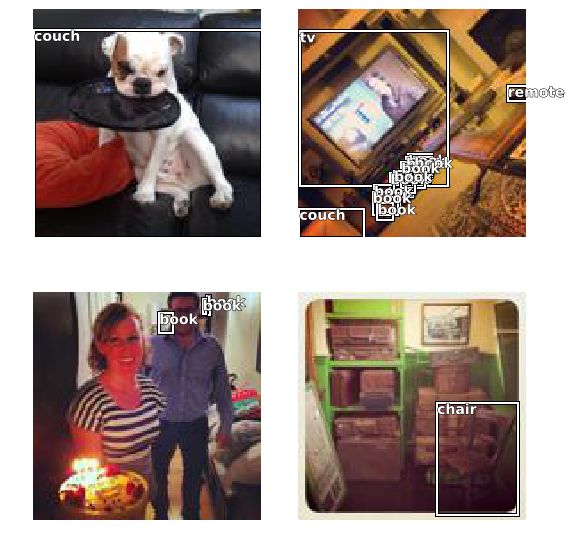

In [10]:
data = get_data()
data.show_batch(rows=2)

## HeLa Cells

In [18]:
path = Path('/home/sudosharma/projects/data/hela')
path.ls()

[PosixPath('/home/sudosharma/projects/data/hela/02'),
 PosixPath('/home/sudosharma/projects/data/hela/models'),
 PosixPath('/home/sudosharma/projects/data/hela/02_GT'),
 PosixPath('/home/sudosharma/projects/data/hela/01'),
 PosixPath('/home/sudosharma/projects/data/hela/01_GT')]

In [19]:
class BinaryImageSegment(ImageSegment):
    @property
    def data(self):
        return self.px.float()

class BinarySegmentationLabelList(SegmentationLabelList):
    """Convert multi-instance label to background vs. cell binary segmentation."""
    def open(self, fn):
        mask = open_image(fn, div=False, convert_mode='L', cls=BinaryImageSegment)
        mask.px = (mask.px.sigmoid()>0.5).float()
        return mask
    
    def reconstruct(self, t): return BinaryImageSegment(t)

In [20]:
def get_img_lbls(path, seq):
    """Obtain the corresponding label for each image that actually has a segmented counterpart."""
    lbl = [l.name[-7:-4] for l in (path/f'0{seq}_GT'/'SEG').ls()]
    img = [i.name for i in (path/f'0{seq}').ls() if i.name[-7:-4] in lbl]
    return img

def get_data(path=path, sz=512, bs=1):
    """Create data loader with different batch sizes and size of image."""
    ifiles = get_img_lbls(path, 1) + get_img_lbls(path, 2)
    get_y_fn_base = lambda path, o: path/f'0{o.stem[0]}_GT'/'SEG'/f'{o.stem[0]}man_seg{o.stem[-3:]}{o.suffix}'
    get_y_fn = partial(get_y_fn_base, path)
    return (SegmentationItemList
            .from_folder(path)
            .filter_by_folder(include=['01', '02'])
            .filter_by_func(lambda fname: fname.name in ifiles)
            .split_by_rand_pct(0.1)
            .label_from_func(get_y_fn, label_cls=BinarySegmentationLabelList, classes=np.array(['back', 'cell']))
            .transform(get_transforms(flip_vert=True, max_warp=0.5), tfm_y=True, size=sz)
            .databunch(bs=bs))

def get_weights(data):
    """Obtain weights to balance class frequencies."""
    data_balance = (torch.stack([f[1].data.sum()for f in data.train_ds])
                    .float()/(512*512)).sum()/len(data.train_ds)
    return torch.stack([data_balance, (1-data_balance)])

In [21]:
data = get_data(bs=8)
weights = get_weights(data)
weights

tensor([0.4935, 0.5065])

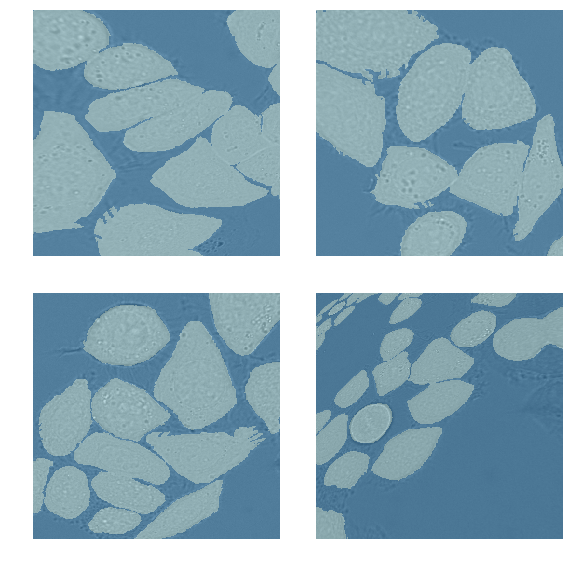

In [22]:
data.show_batch(2)

## UpDownNet

In [23]:
def conv(ci=512, co=256, k=1, s=1): return nn.Conv2d(ci, co, k, stride=s, padding=k//2)
def upsample(ci=256, co=256, k=2, s=2): 
    return nn.Sequential(nn.ConvTranspose2d(ci, co, k, stride=s), nn.ReLU(True), nn.BatchNorm2d(co))

def binary_dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [122]:
class UpDownNet(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.up = create_body(backbone, pretrained=pretrained)
        self.down = nn.Sequential(
            conv(), 
            upsample(),
            upsample(),
            upsample(),
            upsample(), 
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self, x):
        pred = self.down(self.up(x))
        return pred

In [183]:
backbone = models.resnet34
model = UpDownNet(backbone)
learn = Learner(data, 
                model, 
                opt_func=partial(optim.SGD, momentum=0.99), 
                metrics=[partial(accuracy_thresh, thresh=0.5), binary_dice],
                loss_func=partial(F.binary_cross_entropy_with_logits, pos_weight=weights[-1]))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


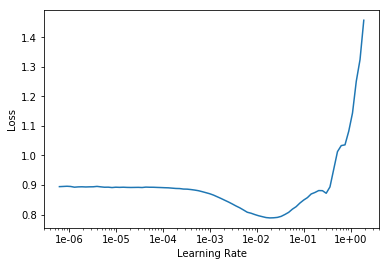

In [172]:
learn.lr_find()
learn.recorder.plot()

In [184]:
callbacks = [
    SaveModelCallback(learn, monitor='binary_dice', mode='max', name='updownnet'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=30, min_delta=0.01)]
learn.callbacks.extend(callbacks)

In [185]:
learn.fit(500, 1e-02)

epoch,train_loss,valid_loss,accuracy_thresh,binary_dice,time
0,0.897187,0.502624,0.552326,0.000000,00:01
1,0.893341,0.500847,0.552326,0.000000,00:01
2,0.891873,0.499078,0.552326,0.000000,00:01
3,0.895202,0.497252,0.552326,0.000000,00:01
4,0.891207,0.495327,0.552326,0.000000,00:01
5,0.885730,0.493358,0.552326,0.000000,00:01
6,0.878675,0.491358,0.552326,0.000000,00:01
7,0.872789,0.489300,0.552326,0.000000,00:01
8,0.866416,0.487191,0.552326,0.000000,00:01
9,0.858028,0.485017,0.552326,0.000000,00:01


Better model found at epoch 0 with binary_dice value: 0.0.
Better model found at epoch 11 with binary_dice value: 0.00020448329451028258.
Better model found at epoch 12 with binary_dice value: 0.0010219115065410733.
Better model found at epoch 13 with binary_dice value: 0.005639784038066864.
Better model found at epoch 14 with binary_dice value: 0.015170072205364704.
Better model found at epoch 15 with binary_dice value: 0.03261096775531769.
Better model found at epoch 16 with binary_dice value: 0.0646662637591362.
Better model found at epoch 17 with binary_dice value: 0.11726909875869751.
Better model found at epoch 18 with binary_dice value: 0.19129431247711182.
Better model found at epoch 19 with binary_dice value: 0.2599523961544037.
Better model found at epoch 20 with binary_dice value: 0.3284904956817627.
Better model found at epoch 21 with binary_dice value: 0.39412185549736023.
Better model found at epoch 22 with binary_dice value: 0.459615021944046.
Better model found at epoch

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 177, in c

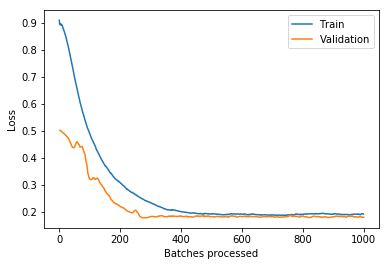

In [186]:
learn.recorder.plot_losses()

In [191]:
x, y = data.train_ds[0]
x = x.data.unsqueeze(0).cuda()
y = y.data.cuda()
pred = learn.pred_batch(batch=(x, y), reconstruct=True)[0]
truth = Image(y)

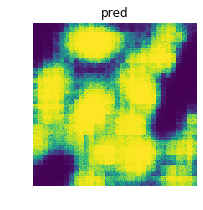

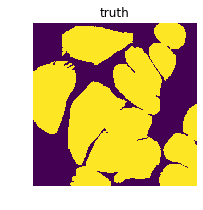

In [192]:
pred.show(title='pred'); truth.show(title='truth')

## FPN (single output)

In [144]:
def conv(ci=512, co=256, k=1, s=1): return nn.Conv2d(ci, co, k, stride=s, padding=k//2).cuda()

In [145]:
class FPN(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.backbone = create_body(backbone, pretrained=pretrained)
        self.hooks = hook_outputs(self.backbone[4:])
        self.conv = conv()
        self.ups = nn.ModuleList(upsample() for u in range(4))
        self.t_conv = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self, x):
        out = self.conv(self.backbone(x))
        maps = [o.stored for o in self.hooks][::-1]
        for i, u in enumerate(self.ups):
            c = conv(ci=maps[i].shape[1])
            out = u(out) + c(maps[i])
        return self.t_conv(out)
    
    def remove(self):
        self.hooks.remove()

In [146]:
backbone = models.resnet34
model = FPN(backbone).cuda()
learn = Learner(data, 
                model, 
                opt_func=partial(optim.SGD, momentum=0.99), 
                metrics=[partial(accuracy_thresh, thresh=0.5), binary_dice],
                loss_func=partial(F.binary_cross_entropy_with_logits, pos_weight=weights[-1]))

In [147]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 3

<b>TODO:</b>
1. pull pretrained resnet
- cut base model
- extract feature maps from pretrained resnet using fastai hooks
- concat feature maps in cross-connections with convs, and build cross connections
- incorporate predictions at each level using 3by3 conv
- figure out focal loss
- add classification subnet
- add regression subnet
- train on coco tiny
- train on coco
- see if you can match paper